# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

**TODO**:
- quantify run times
- figure out overflow
- make sure quadcopter converges

In [1]:
from time import perf_counter as pc
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import split_agents
import decentralized as dec
import pocketknives

π = np.pi

In [2]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control, decentralized.dynamics, decentralized.cost, decentralized.problem, decentralized.util

In [3]:
%matplotlib ipympl
plt.rcParams['axes.grid'] = True

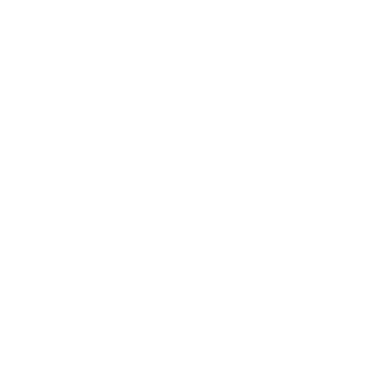

In [4]:
fig = plt.figure(figsize=(3.7, 3.7))
# fig = plt.figure()

In [6]:
def plot_solve(X, J, x_goal, x_dims=None, n_d=2):
    """Plot the resultant trajectory on plt.gcf()"""
    
    if n_d not in (2, 3):
        raise ValueError()
    
    if not x_dims:
        x_dims = [X.shape[1]]
        
    if n_d == 2:
        ax = plt.gca() 
    else:
        ax = fig.add_subplot(projection="3d")

    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_agents(X, x_dims)
    x_goal_split = split_agents(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        if n_d == 2:
            ax.scatter(Xi[:,0], Xi[:,1], c=t)
            ax.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
            ax.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
        else:
            ax.scatter(Xi[:,0], Xi[:,1], Xi[:,2], c=t)
            ax.scatter(Xi[0,0], Xi[0,1], Xi[0,2], s=80, c='g', marker='x', label="$x_0$")
            ax.scatter(xg[0,0], xg[0,1], xg[0,2], s=80, c='r', marker='x', label="$x_f$")
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")
    plt.draw()

## single-agent problem

In [7]:
dt = 0.05
N = 50
n_d = 2

x = np.array([-10, 10, 10, 0], dtype=float)
x_goal = np.zeros((4, 1), dtype=float).T

# dynamics = dec.DoubleIntDynamics4D(dt)
dynamics = dec.UnicycleDynamics4D(dt)

Q = np.diag([1., 1, 0, 0])
Qf = 1000 * np.eye(Q.shape[0])
R = np.eye(2)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal)
plt.draw()

0/50	J: 432856
1/50	J: 4390.33	μ: 0.5	Δ: 0.5
2/50	J: 4096.25	μ: 0.125	Δ: 0.25
3/50	J: 3473.41	μ: 0.015625	Δ: 0.125
4/50	J: 3428.29	μ: 0.000976562	Δ: 0.0625
5/50	J: 3371.06	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3263.24	μ: 0	Δ: 0.015625
7/50	J: 3236.36	μ: 0	Δ: 0.0078125
8/50	J: 3211.05	μ: 0	Δ: 0.00390625
9/50	J: 3206.25	μ: 0	Δ: 0.00195312
10/50	J: 3198.65	μ: 0	Δ: 0.000976562


Show equations of motion, which have the form

$$\dot{x} = f(x, u, p)$$

for states

$$
x = \begin{bmatrix} o_x & o_y & o_z & \psi & \theta & \phi & v_x & v_y & v_z & w_x & w_y & w_z \end{bmatrix},
$$

inputs
$$
u = \begin{bmatrix} \tau_x & \tau_y & \tau_z & f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m & J_x & J_y & J_z & g \end{bmatrix}.
$$

In [8]:
# Single-agent problem for a quadcopter (w/ analytical diff.)
dt = 0.05
N = 50
n_d = 3

x = np.array([2, 2, 0.5 , 0.05, 0, 0, 0.0, 0.0, 0, 0, 0, 0], dtype=float)
x_goal = np.zeros((12, 1), dtype=float).T

dynamics = dec.QuadcopterDynamics12D(dt)

# Q = np.diag([1., 1., 1., 0, 0, 0, 0, 0, 0, 0, 0, 0])
Q = np.diag([1., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Qf = 100 * np.eye(Q.shape[0])
R = np.eye(4)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

# with warnings.catch_warnings():
    # warnings.filterwarnings("error")
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal, n_d=n_d)
plt.draw()

0/50	J: 170465
1/50	J: 6124.45	μ: 0.5	Δ: 0.5
2/50	J: 355.785	μ: 0.125	Δ: 0.25
3/50	J: 319.384	μ: 0.015625	Δ: 0.125
4/50	J: 263.571	μ: 0.000976562	Δ: 0.0625
5/50	J: 255.398	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 250.468	μ: 0	Δ: 0.015625
7/50	J: 249.248	μ: 0	Δ: 0.0078125
8/50	J: 248.429	μ: 0	Δ: 0.00390625


## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [8]:
def paper_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = np.array([[0.5, 1.5, 0, 0.1,
                    2.5, 1.5, 0, π,
                    1.5, 1.3, 0, π/2]], 
                     dtype=float).T
    x_goal = np.array([[2.5, 1.5, 0, 0, 
                        0.5, 1.5, 0, π, 
                        1.5, 2.2, 0, π/2]]).T
    return x0, x_goal

def car_setup():
    """Same as paper_setup but using car dynamics"""
    x0, x_goal = paper_setup()
    car_mask = [i % 4 < 3 for i in range(x0.shape[0])]
    return x0[car_mask], x_goal[car_mask]

def bike_setup():
    """Same as paper_setup but using bike dynamics"""
    N_AGENTS = 3
    N_STATES = 5
    n_total_states = N_AGENTS * N_STATES
    bike_mask = [i % 5 < 4 for i in range(n_total_states)]
    
    x0, x_goal = paper_setup()
    x0_bike = np.zeros((n_total_states, 1))
    x_goal_bike = np.zeros_like(x0_bike)
    x0_bike[bike_mask] = x0
    x_goal_bike[bike_mask] = x_goal
    
    return x0_bike, x_goal_bike

def double_int_setup():
    x0, x_goal = paper_setup()
    theta_mask = [i % 4 == 3 for i in range(x0.shape[0])]
    x0[theta_mask] = 0.0
    x_goal[theta_mask] = 0.0

    return x0, x_goal

def dec_test_setup():
    x0, x_goal = paper_setup()
    x0_other = np.array([[5, 5, 0, 0,
                          6, 6, 0, π/4]]).T
    x_goal_other = np.array([[6, 4, 0, -π/2,
                              4, 6, 0, π/4]]).T
    
    x0 = np.concatenate([x0, x0_other]) 
    x_goal = np.concatenate([x_goal, x_goal_other])    
    
    return x0, x_goal

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

In [13]:
dec.QuadcopterDynamics12D(-1).n_x

12

In [9]:
n_agents = 4
n_states = 4
n_controls = 2
ENERGY = 10.0
n_d = 2

# x0, x_goal = paper_setup()
# x0, x_goal = car_setup()
# x0, x_goal = bike_setup()
# x0, x_goal = double_int_setup()
# x0, x_goal = dec_test_setup()
x0, x_goal = dec.random_setup(
    n_agents, n_states, 
    is_rotation=True, 
    rel_dist=3.0, 
    var=1.0, 
    n_d=n_d, 
    random=False
)

x_dims = [n_states] * n_agents
u_dims = [2] * n_agents

x0 = normalize_energy(x0, x_dims, ENERGY)
# x_goal = normalize_energy(x_goal, x_dims, ENERGY)
# x0 = perturb_state(x0, x_dims)

plt.clf()
plt.gca().set_aspect('equal')
X = np.dstack([
    x0.reshape(n_agents, n_states), 
    x_goal.reshape(n_agents, n_states)
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[i]))
pocketknives.set_bounds(X.reshape(-1, n_states), zoom=0.2)
plt.draw()

NameError: name 'normalize_energy' is not defined

In [19]:
dt = 0.1
N = 40
tol = 1e-3
ids = [100 + i for i in range(n_agents)]

# model = dec.DoubleIntDynamics4D
model = dec.UnicycleDynamics4D
# model = dec.BikeDynamics5D
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_ in ids])

Q = 1.0 * np.diag([1, 1, 0, 0])
Qf = 1000 * np.eye(Q.shape[0])
R = np.eye(2)

# radius = ENERGY / 20
radius = 0.5

goal_costs = [dec.ReferenceCost(x_goal_i, Q.copy(), R.copy(), Qf.copy(), id_) 
              for x_goal_i, id_ in zip(split_agents(x_goal.T, x_dims), ids)]
prox_cost = dec.ProximityCost(x_dims, radius)
game_cost = dec.GameCost(goal_costs, prox_cost)

prob = dec.ilqrProblem(dynamics, game_cost)

NameError: name 'n_agents' is not defined

In [41]:
%%prun
# %%time
ilqr = dec.ilqrSolver(prob, N)
t0 = pc()
X, U, J = ilqr.solve(x0, tol=tol, t_kill=None)

0/50	J: 213011
1/50	J: 17396.1	μ: 0.5	Δ: 0.5
2/50	J: 3099.51	μ: 0.125	Δ: 0.25
3/50	J: 3083.25	μ: 0.015625	Δ: 0.125
4/50	J: 3072.81	μ: 0.000976562	Δ: 0.0625
5/50	J: 3068.3	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3040.3	μ: 0	Δ: 0.015625
7/50	J: 3031.65	μ: 0	Δ: 0.0078125
 

         855327 function calls (805235 primitive calls) in 6.281 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      640    1.374    0.002    1.440    0.002 linalg.py:320(solve)
     8130    0.320    0.000    1.104    0.000 shape_base.py:739(array_split)
87315/37223    0.310    0.000    3.636    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    48780    0.231    0.000    0.656    0.000 fromnumeric.py:51(_wrapfunc)
    40650    0.183    0.000    0.745    0.000 <__array_function__ internals>:177(swapaxes)
    14626    0.179    0.000    0.240    0.000 shape_base.py:81(atleast_2d)
     1624    0.157    0.000    0.869    0.001 _special_matrices.py:470(block_diag)
      328    0.143    0.000    0.218    0.001 cost.py:118(quadraticize)
        8    0.143    0.018    3.819    0.477 control.py:116(_backward_pass)
     3248    0.140    0.000    0.285    0.000 numerictypes.py:573(_can_coerce_all)
    

In [36]:
plt.clf()
plot_solve(X, J, x_goal.T, x_dims, n_d)

In [13]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X, x_dims, n_d).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

In [14]:
costs = []
for xi, ui in zip(X, U):
    costs.append(game_cost(xi, ui).item())
plt.clf()
plt.plot(costs)
plt.draw()

## decentralized multi-agent

In [15]:
graph = dec.define_inter_graph_threshold(X, radius, x_dims, ids)
graph

{100: [100, 101], 101: [100, 101]}

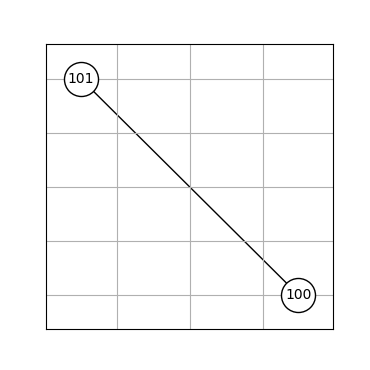

In [32]:
plt.clf()
dec.plot_interaction_graph(graph)

In [16]:
%%time
X0 = np.tile(x0.T, (N,1))
U0 = np.zeros((N, n_controls*n_agents))
X_dec, U_dec, J_dec = dec.solve_decentralized(prob, X0, U0, radius, is_mp=False)

Interaction Graph: {100: [100], 101: [101]}
0/50	J: 42357
1/50	J: 6448.23	μ: 0.5	Δ: 0.5
2/50	J: 612.787	μ: 0.125	Δ: 0.25
3/50	J: 606.489	μ: 0.015625	Δ: 0.125
4/50	J: 601.486	μ: 0.000976562	Δ: 0.0625
5/50	J: 599.625	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 598.097	μ: 0	Δ: 0.015625
7/50	J: 596.911	μ: 0	Δ: 0.0078125
8/50	J: 595.865	μ: 0	Δ: 0.00390625
9/50	J: 595.044	μ: 0	Δ: 0.00195312
10/50	J: 594.311	μ: 0	Δ: 0.000976562
Problem 100: [100]
Took 2.3821368999997503 seconds
0/50	J: 55951.1
1/50	J: 3820.95	μ: 0.5	Δ: 0.5
2/50	J: 788.442	μ: 0.125	Δ: 0.25
Problem 101: [101]
Took 0.7344357000038144 seconds
CPU times: user 7.65 s, sys: 4.28 s, total: 11.9 s
Wall time: 3.2 s


In [17]:
plt.clf()
plot_solve(X_dec, J_dec, x_goal, x_dims, n_d)

In [35]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X_dec, x_dims, n_d).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

## receding horizon

In [24]:
step_size = 10
U0 = np.zeros((N, dynamics.n_u))
X, U, J = dec.solve_rhc(
    prob, x0, N, radius,
    centralized=True,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=1.0,
    verbose=False,
    t_kill=step_size*dt
)

In [25]:
plt.clf()
plot_solve(X, J, x_goal, x_dims, n_d)

## animation

In [52]:
_, axes = plt.subplots(1, 2, figsize=(5.0, 3.7))

In [37]:
def setup(axes, X, x_goal, x_dims, radius):
    
    ax1, ax2 = axes
    n_agents = len(x_dims)
    handles1 = []
    for i in range(n_agents):
        handles1.append((
            ax1.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax1.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2)),
        ))
        
    for xg in split_agents(x_goal, x_dims):
        ax1.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, axes[0], zoom=0.15)
    plt.draw()
    
    handles2 = []
    n_pairs = pocketknives.nchoosek(n_agents, 2)
    for i in range(n_pairs):
        handles2.append(ax2.plot(0, c=plt.cm.tab20.colors[2*i])[0])
    ax2.hlines(radius, 0, X.shape[0], 'r', ls='--')
    ax2.set_ylim(0.0, distances.max())
        
    return handles1, handles2
    
def animate(t, handles1, handles2, X, x_dims, x_goal, distances):
    """Animate the solution into a gif"""
    
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles1):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
        
    for i, hi in enumerate(handles2):
        hi.set_xdata(range(t))
        hi.set_ydata(distances[:t, i])
    
    plt.draw()
    

In [51]:
distances = dec.compute_pairwise_distance(X, x_dims).T
handles1, handles2 = setup(axes, X, x_goal.flatten(), x_dims, radius)
animate(10, handles1, handles2, X, x_dims, x_goal, distances)
plt.draw()

In [53]:
handles = setup(axes, X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(
    plt.gcf(), 
    animate, 
    frames=N+1, 
    fargs=(*handles, X, x_dims, x_goal, distances))
anim.save('traj.gif', fps=5)

## old

In [ ]:
# Old RHC for plotting...
rhc = dec.RecedingHorizonController(x0, ilqr, step_size=5)
U0 = np.zeros((ilqr.N, ilqr.n_u))
for Xi, Ui, Ji in rhc.solve(U0, J_converge=101.0, tol=tol, verbose=False):
    plt.cla()
    plot_solve(Xi, Ji, x_goal.T, x_dims)
    fig.canvas.draw()

In [ ]:
# Manual decentralized RHC for plotting...
step_size = 5
Xi = np.tile(x0.T, (N,1))
Ui = np.zeros((N, dynamics.n_u))
X_dec = np.zeros((0, dynamics.n_x))
U_dec = np.zeros((0, dynamics.n_u))
Ji = np.inf
J_converge = 100.0

while Ji >= J_converge:
    Xi, Ui, Ji = dec.solve_decentralized(prob, Xi, Ui, radius, is_mp=False)
    
    X_dec = np.r_[X_dec, Xi[:step_size]]
    U_dec = np.r_[U_dec, Ui[:step_size]]
    
    # Seed the next solve by staying at the last visited state.
    Xi = np.r_[Xi[step_size:], np.tile(Xi[-1], (step_size, 1))]
    Ui = np.r_[Ui[step_size:], np.zeros((step_size, dynamics.n_u))]
    
    plt.cla()
    plot_solve(Xi[:step_size], Ji, x_goal.T, x_dims)
    fig.canvas.draw()

Interaction Graph: {100: [100], 101: [101]}
0/50	J: 34197.1
1/50	J: 4938.39	μ: 0.5	Δ: 0.5
2/50	J: 491.356	μ: 0.125	Δ: 0.25
3/50	J: 485.593	μ: 0.015625	Δ: 0.125
4/50	J: 481.134	μ: 0.000976562	Δ: 0.0625


KeyboardInterrupt: 